# Data Analysis of P2P market as MAD problem
We evaluate the results of the simulation of a prosumer participating in a fully decentralized P2P market. This work is modelled as Multi-armed Bandit problem, a classic control problem that we can apply RL techniques.

This analysis starts by looking to the results presented in the Informs talk as ''Prosumer choice formulatedas Multi Armed Bandit problem - RL application''.

This notebook analyses the simulation saved on the `/results` folder of the GitHub repo ([link here])(https://github.com/tabsa/P2P_market_MAD).

In [1]:
# Import packages
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

Start with upload the simulations done for the Informs talk that shows the first results with this work:

In [2]:
# Read pickle file
wok_dir = Path.cwd() / 'results/'
filename = 'training_results_30_partners.pkl'
path_file = wok_dir / filename
data = pkl.load(open(path_file, 'rb')) # Read file
# Plot parameters
plt_colmap = plt.get_cmap("tab10", 15)
sns.set_style("whitegrid")


Deploy functions for plotting. Each function will be used to plot a different result out of the simulation:

In [3]:
## Define Plot functions

# Plot the mean reward per episode and RL_agent (You can have cumulative option as well)
def plot_reward_per_episode(df_score, y_feat, plt_label, plt_marker, size=(10,8), y_sum=False):
    # Get the plot parameters
    no_RL_agents = len(df_score) # Number of agents
    no_episodes = df_score[0].shape[0]
    plt.figure(figsize=size)
    x = np.arange(0, no_episodes) # Episode range
    for i in range(no_RL_agents):
        y = df_score[i][y_feat]
        y = np.cumsum(y) if y_sum else y # Cumulative plot
        plt.plot(x, y, label=plt_label[i], marker=plt_marker[i], linestyle='--')
        
# Plot the Q-action value per episode and RL_agent
def plot_Q_val_distribution(df_score, theta, plt_label, n_bins=20, size=(10,8)):
    from statsmodels.distributions.empirical_distribution import ECDF
    # Get the plot parameters
    no_RL_agents = len(df_score)
    no_episodes = df_score[0].shape[0]
    fig, axis = plt.subplots(1, 2, figsize=size, sharex=True)
    x = np.arange(0, no_episodes)
    for i in range(no_RL_agents):
        x = df_score[i][theta]
        axis[0].hist(x, density=True, bins=n_bins, label=plt_label[i])
        ecdf = ECDF(x)
        axis[1].plot(ecdf.x, ecdf.y, label=plt_label[i]) 
    return fig, axis

# Plot the policy per agent per episode
def plot_action_choice(policy, target, epi_id, y_lim, size=(10,8)):
    # Plot parameters
    no_steps = policy.shape[1]
    fig, axis = plt.subplots(3, 1, figsize=size, sharex=True)
    x = np.arange(0, no_steps) # Steps of the episode (0 ... N)
    y1 = policy[0,:,epi_id].astype(int) # Partner selected per x-value (n_step)
    target = target * np.ones(no_steps) # Array of energy_target for all n_steps of the episode
    # Subplot 1
    axis[0].scatter(x, y1, cmap=plt_colmap, c=y1, marker='.', alpha=1)
    axis[0].set_yticks(np.arange(0, y_lim, step=2))
    # Subplot 2
    axis[1].plot(x, policy[4, :, epi_id], color='green', label='Total reward')
    axis[1].plot(x, policy[3, :, epi_id], color='green', alpha=0.5, linestyle='--', label='Reward_per_step')
    axis[1].set_yticks(np.linspace(0, 1, 6))
    # Subplot 3
    axis[2].bar(x, policy[1, :, epi_id])
    axis[2].plot(x, policy[2, :, epi_id], color='cyan', marker='o', label='state_n')
    axis[2].plot(x, target, color='red', linestyle='--', label='E_target')
    axis[2].set_yticks(np.linspace(0, target.max(), 4))
    return fig, axis

# Plot the optimal estimator Q_arm_j
def plot_final_probability(data, agents, epi_rg, p_j, plt_label, width=0.15, size=(10,8)):
    # Plot parameters
    no_RL_agents = len(data)
    no_offers = data[0].shape[1]
    x = np.arange(no_offers)
    # Initialize plot
    fig, ax = plt.subplots(figsize=size)
    ax.bar(x, p_j, width, label='True probability') # Always plot the True probability
    # Options selected by the user --> idx is the list of RL_agents 
    k=1
    for i in agents:
        Q_opt_arm_j = data[i][epi_rg,:,0].mean(axis=0)
        ax.bar(x + width*k, Q_opt_arm_j, width, label=plt_label[i])
        k += 1
    
    ax.set_xticks(x)
    return fig, ax
        

## Total reward $R_{Total}$ evolution per episode
$R^i_{Total}$ is mean reward, given by
\begin{equation}
    R^i_{Total} = \frac{1}{N_i} \sum_n R^i_n
\end{equation} <br>
where $N_i$ is the total number of steps per episode $i$ and $R^i_n$ is the reward per step $n$ (also called reward signal). In fact, $R^i_{Total}$ is constantly updated every step $n$ of each episode $i$.

Here, we plot the $R^i_{Total}$ on the final step $n$ for all episodes with the following conditions:
 - The same Energy_target = 15 kWh for all episodes $i$. 
 - Non-existing correlation, i.e. episodes are independent from each other
 - For the first 20 episodes, all startegies adopt a 'Random policy' for learning the Q-value $Q_n(j)$ of each partner $j$
 - **Goal:** Evaluate the learning process of each policy (Random, Epsilon-greedy, Thompson-Sampler). If the *Epsilon-greedy* and *Thompson-Sampler* beat **constantly** the *Random policy*
 - You can disable the cumulative plot in the function `plot_reward_per_episode` by switching the last parameter from `False` to `True`

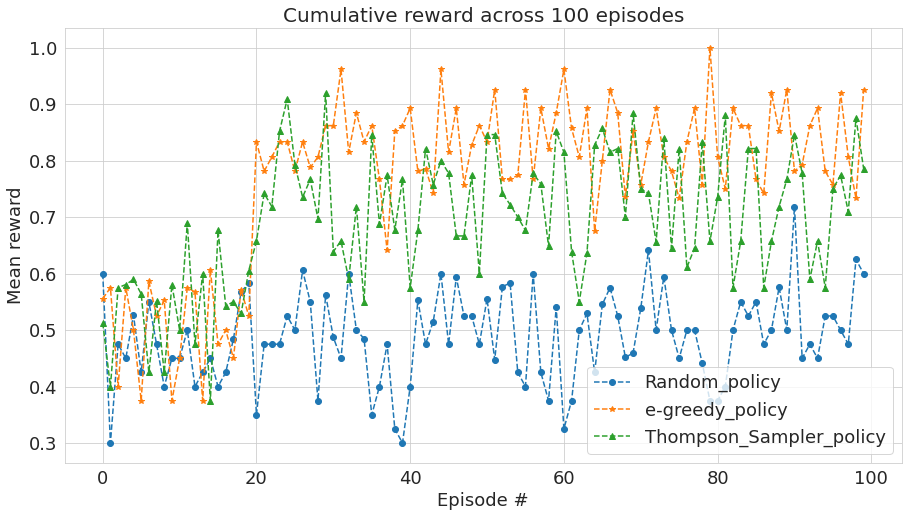

In [9]:
no_epi = data['simulation']['episodes']
label = data['agents']['id']
marker = ['o', '*', '^']
ax_label = ['Episode #', 'Mean reward']
ax_size = 18
plot_reward_per_episode(data['outcome'], 'mean_rd', label, marker, (15,8))
# Legend and labels for the plot
plt.legend(fontsize=ax_size)
plt.ylabel(ax_label[1], fontsize=ax_size)
plt.xticks(fontsize=ax_size)
plt.yticks(fontsize=ax_size)
plt.xlabel(ax_label[0], fontsize=ax_size)
plt.title(f'Cumulative reward across {no_epi} episodes', fontsize=20)
plt.show()

**Takeaways:** Both strategies outperform the *Random policy*, but the *Epsilon-greedy* reached out the best results.

## Regret $G_{Total}$ per episode
Here we plot the estimated mean regret, if you remember the formulate. The regret is calculated as
\begin{equation}
    G^i_{Total} = \frac{1}{N_i} \sum_n\left[ \max(Q^i_n(j) - Q^i_n(j) \right]
\end{equation} <br>
where $Q^i_n(j)$ is Q-value of partner/arm $j$ per step $n$. Q_n is a vector with the updated Action-value function per partner $j$, so we update it every step $n$. We use $Q_n$ because we are unaware of the **Probability Distribution**, Bernoulli $B(1, p_j)$ of each offer (partner $j$).

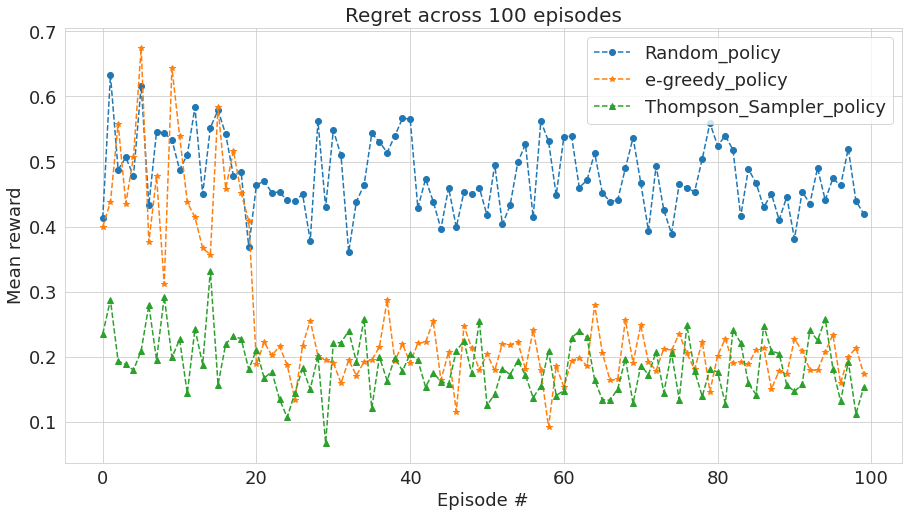

In [5]:
no_epi = data['simulation']['episodes']
label = data['agents']['id']
marker = ['o', '*', '^']
ax_label = ['Episode #', 'Mean reward']
ax_size = 18
plot_reward_per_episode(data['outcome'], 'mean_regret', label, marker, (15,8))
# Legend and labels for the plot
plt.legend(fontsize=ax_size)
plt.ylabel(ax_label[1], fontsize=ax_size)
plt.xticks(fontsize=ax_size)
plt.yticks(fontsize=ax_size)
plt.xlabel(ax_label[0], fontsize=ax_size)
plt.title(f'Regret across {no_epi} episodes', fontsize=20)
plt.show()

**Takeaways:** The regret in both strategies is low afgter the initial learning phase. However, we have approx. 0.3 of regret which it is not ideal for our simulations.

## Empirical distribution and Histogram of the $R_{Total}$ and $G_{Total}$
Here we want to find some trend from the empirical CDF and histogram of the results for all episodes, se once again we plot the $R^i_{Total}$ and $G^i _{Total}$.

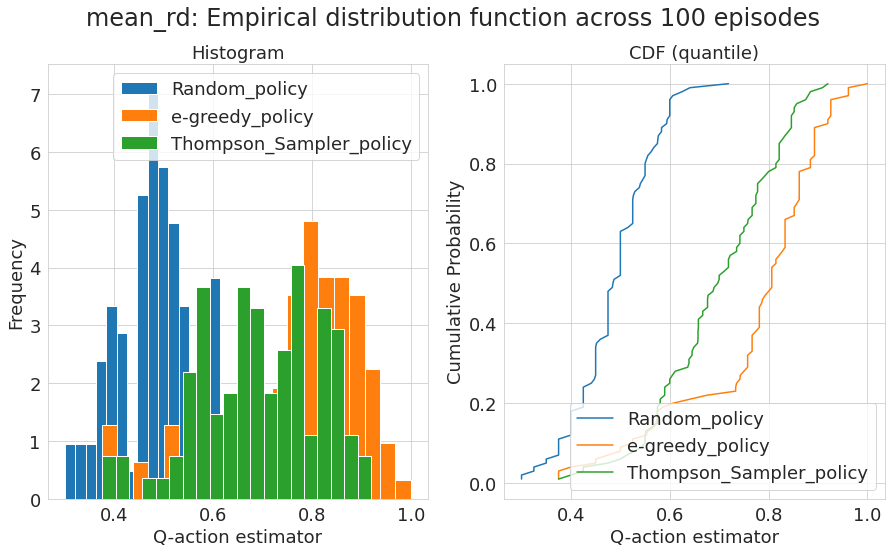

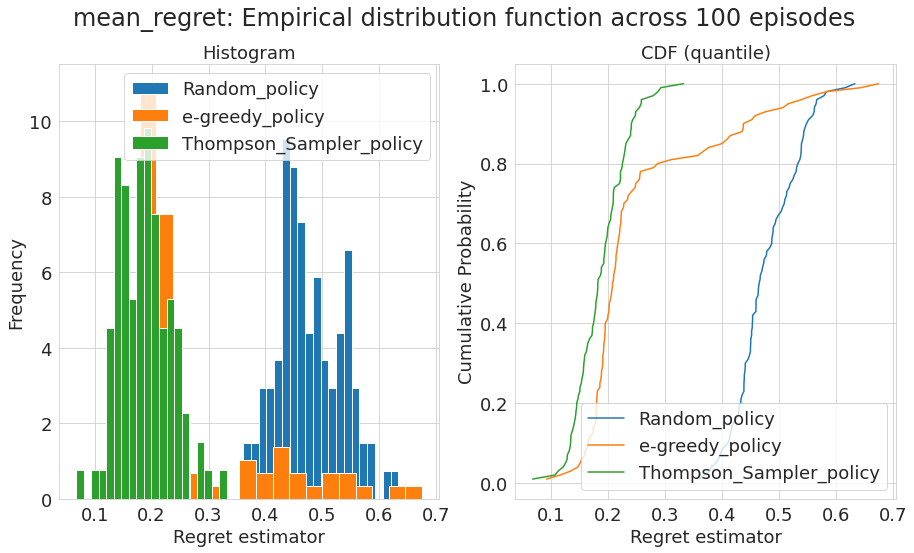

In [6]:
# Show the histogram and CDF of Q-action value, since it is probability estimator
theta_feat = ['mean_rd', 'mean_regret']
ax_label = ['Q-action estimator', 'Regret estimator', 'Frequency', 'Cumulative Probability']
subplot_title = ['Histogram', 'CDF (quantile)']
for theta in theta_feat:
    fg, ax = plot_Q_val_distribution(data['outcome'], theta, label, size=(15,8)) # Only plotting 'Random' and 'Epsilon-greedy'
    # Legend and labels for the plot
    [ax[i].legend(fontsize=ax_size) for i in range(len(ax))]
    x_id_label = 0 if theta == theta_feat[0] else 1
    [ax[i].set_xlabel(xlabel=ax_label[x_id_label], fontsize=ax_size) for i in range(len(ax))]
    [ax[i].set_ylabel(ylabel=ax_label[i+2], fontsize=ax_size) for i in range(len(ax))]
    [ax[i].tick_params(axis='x', labelsize=ax_size) for i in range(len(ax))]
    [ax[i].tick_params(axis='y', labelsize=ax_size) for i in range(len(ax))]
    # Set title
    [ax[i].set_title(subplot_title[i], fontsize=18) for i in range(len(ax))]
    fg.suptitle(f'{theta}: Empirical distribution function across {no_epi} episodes', fontsize=24)
    plt.show()


## Analyse the Optimal policy $\pi^{\ast}(a_n)$
Now we dive into the optimal solution (also called policy) found by each strategy. It is only important to have a look to the policy on the last episodes, because we expect each strategy converges to its optimal in the last episodes.

You can analyse the policy by playing around with the following parameters:
 - `ag_id`: id of the RL_agent with a strategy (0: Random; 1: Epsilon-greedy; 2: Thompson-Sampler)
 - `epi_id`: episode id and please only have a look from eq epi_id = $[89 - 99]$
 - By playing with these two parameters below, you can see the performance of each strategy
 - **Remember:** Python indexes are $n-1$ and start from $0$, so our episodes start from $0$ and stop to $99$.

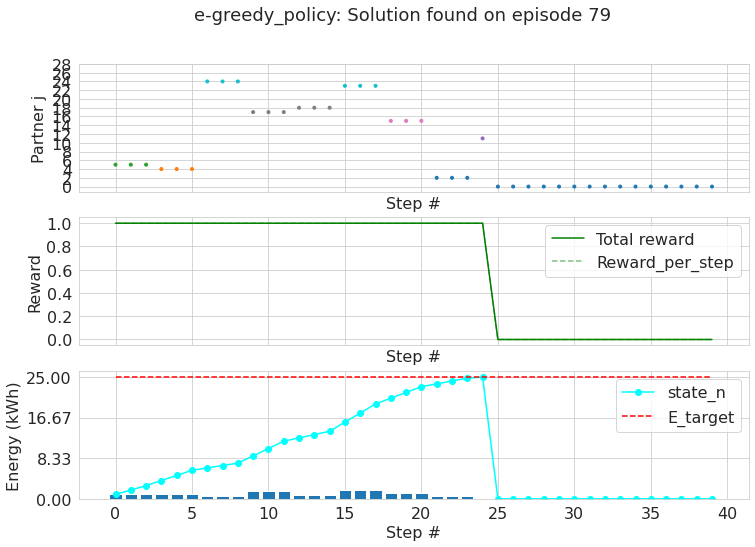

In [11]:
# Result data structure
pol_sol = data['policy_sol'] # Optimal policy per agent
e_target = data['simulation']['target'] # Energy target per episode (array)
ag_label = data['agents']['id'] # Agent type (Random, Epsilon-greedy, Thompson-Sampler)
no_offers = data['simulation']['environment'].no_offers # No of offers to trade with
no_epi = data['simulation']['episodes'] # Episodes #
# Plot parameters
ag_id = 1 # Agent type (0, 1, 2...)
epi_id = 79 # Episode id
ax_label = ['Step #', 'Partner j', 'Reward','Energy (kWh)']
ax_size = 16
fig, ax = plot_action_choice(pol_sol[ag_id], e_target[epi_id], epi_id, no_offers, (12,8)) # Make the plot
# Set labels of each subplot
[ax[i].set_xlabel(xlabel=ax_label[0], fontsize=ax_size) for i in range(len(ax))]
[ax[i].set_ylabel(ylabel=ax_label[i+1], fontsize=ax_size) for i in range(len(ax))]
[ax[i].tick_params(axis='x', labelsize=ax_size) for i in range(len(ax))]
[ax[i].tick_params(axis='y', labelsize=ax_size) for i in range(len(ax))]
# Set legend of Subplots 2 and 3
[ax[i].legend(fontsize=ax_size) for i in np.arange(1, len(ax))]
# Set title
#[ax[i].set_title(subplot_title[i], fontsize=18) for i in range(len(ax))]
fig.suptitle(f'{ag_label[ag_id]}: Solution found on episode {epi_id}', fontsize=18)
plt.show()

## Retrieve the estimator $Q^{\ast}_j$ from the optimal policy
Please remember that $Q^{\ast}_j$ is the estimator of probability $p_j = \text{Pr}(X=1)$ from the Bernoulli distribution $B(1, p_j)$. So $p_j$ is the probability of success and over episodes $i$ the Q-value of each partner $j$ estimates the true value of $p_j$, $Q^i_j = \hat{p}_j$, where $\hat{p}_j$ is the estimator. <br>
If we assume to play a large number of episodes $i$, with the same assumptions mentioned before, $Q^i_j$ ends up converges towards its optimal value $Q^{\ast}_j = p_j$. <br>
Here, we compute the $Q^i_j$ for the last 10 episodes:

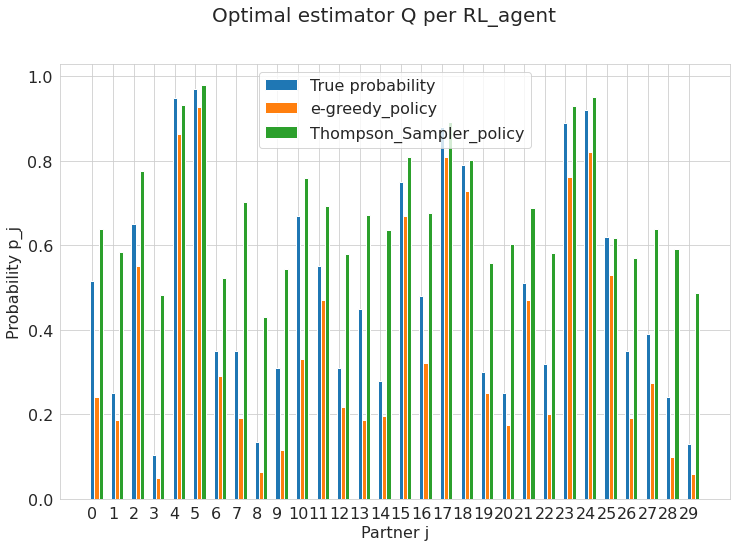

In [8]:
arm_info = data['simulation']['environment'].offers_info # 2-D array with info per arm (col dim: 0-Energy_j, 
                                                         # 1-price_j, 2-Probability_j)
true_p_j = arm_info[:,2] # True probability p_j
poli_distr = data['policy_dist'] # List with Q_arm_j per agent. Each list element is a 3-D array (epi x arms_j x feat)
ag_id = [1, 2] # List of RL_agents to analyse
ep_rg = np.arange(90, 100) # See the last 10 episodes
label = data['agents']['id'] 
# Call the plot function
fig, ax = plot_final_probability(poli_distr, ag_id, ep_rg, true_p_j, label, width=0.2,size=(12,8))
# Set labels and legend
ax.set_xlabel(xlabel='Partner j', fontsize=ax_size)
ax.set_ylabel(ylabel='Probability p_j', fontsize=ax_size)
ax.tick_params(axis='x', labelsize=ax_size)
ax.tick_params(axis='y', labelsize=ax_size)
ax.legend(fontsize=ax_size)
# Set title
fig.suptitle('Optimal estimator Q per RL_agent', fontsize=20)
plt.show()
